In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC, SMOTEN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)

pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('../datasets/dropna_df.csv')

In [3]:
def evaluation(X_test, y_test, preds, model):
    plt.figure(figsize = (10, 8))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='copper')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label = 1)
    prec = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

---

In [4]:
#continuous features only
contin_cols = ['helpful_count', 'num_images', 'num_comments', 'price_low', 'num_reviews', 'num_images_pdp']

# isolate target variable
y = df['grey_sale'].values

In [5]:
smoten = SMOTEN()
# SMOTEN for continuous features

xcon_resam, ycon_resam = smoten.fit_resample(df[contin_cols], y)

# train-test split for SMOTEN resample of continuous features
X_train, X_test, y_train, y_test = train_test_split(xcon_resam, ycon_resam, stratify = ycon_resam, random_state = 22)

In [6]:
# fit / score
rcon = RandomForestClassifier()

rcon.fit(X_train, y_train)

print(f'Training set score: {rcon.score(X_train, y_train)}')

print(f'5-fold cross-validated TEST set average: {cross_val_score(rcon, X_test, y_test).mean()}')

Training set score: 0.9343640064229339
5-fold cross-validated TEST set average: 0.933117480263126


balanced_accuracy: 0.9337065816207459
recall: 0.9700755968378204
precision: 0.9043000512782946
f1 score: 0.9360337271196979


{'balanced_accuracy': 0.9337065816207459,
 'recall': 0.9700755968378204,
 'precision': 0.9043000512782946,
 'f1_score': 0.9360337271196979}

<Figure size 1000x800 with 0 Axes>

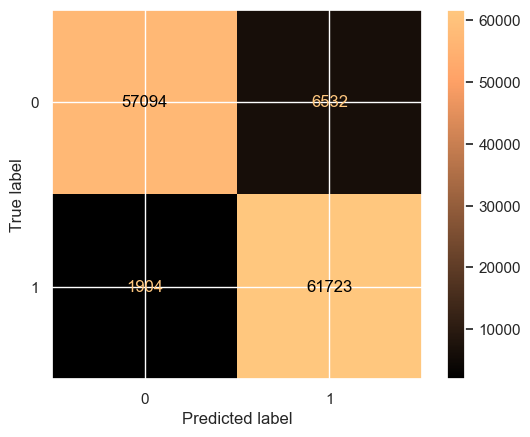

In [7]:
# evaluation metrics
preds = rcon.predict(X_test)
evaluation(X_test, y_test, preds, rcon)

In [8]:
max(rcon.feature_importances_), min(rcon.feature_importances_)

(0.4106630746288389, 0.026764739081322722)

In [9]:
# features and coefficients
features_listed = []

for i in range(len(rcon.feature_names_in_)):
    features_listed.append({rcon.feature_names_in_[i] : rcon.feature_importances_[i]})
    
features_listed

[{'helpful_count': 0.09789428480316734},
 {'num_images': 0.03805184030572018},
 {'num_comments': 0.026764739081322722},
 {'price_low': 0.4106630746288389},
 {'num_reviews': 0.269405638574617},
 {'num_images_pdp': 0.15722042260633384}]

---

In [10]:
# running Logistic Regression with no penalty for interpretability
logr = LogisticRegression(penalty = 'none', max_iter = 1_000, )

logr.fit(X_train, y_train)
           
print(f'Training set score: {logr.score(X_train, y_train)}')

print(f'5-fold cross-validated TEST set average: {cross_val_score(logr, X_test, y_test).mean()}')

Training set score: 0.6493607189914002
5-fold cross-validated TEST set average: 0.6496821552937464


balanced_accuracy: 0.6491957195702991
recall: 0.5462932402910714
precision: 0.6878611572864719
f1 score: 0.6089576818297288


{'balanced_accuracy': 0.6491957195702991,
 'recall': 0.5462932402910714,
 'precision': 0.6878611572864719,
 'f1_score': 0.6089576818297288}

<Figure size 1000x800 with 0 Axes>

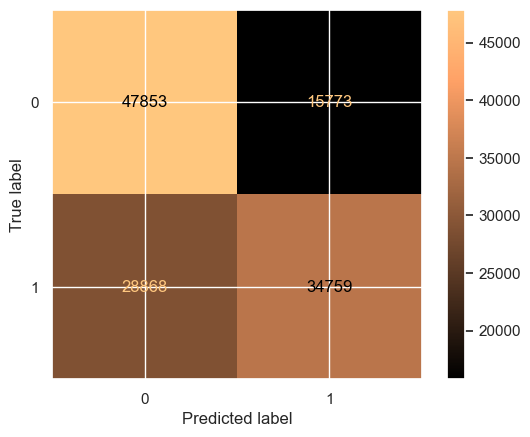

In [11]:
# evaluation metrics
logr_preds = logr.predict(X_test)
evaluation(X_test, y_test, logr_preds, logr)

In [12]:
# features and coefficients
features_listed = []

for i in range(len(logr.feature_names_in_)):
    features_listed.append({logr.feature_names_in_[i] : logr.coef_[0][i]})
    
features_listed

[{'helpful_count': 0.14145760832947696},
 {'num_images': 0.6844295672421775},
 {'num_comments': 0.855304951082772},
 {'price_low': -0.00020195492651877756},
 {'num_reviews': -0.0011782374638884972},
 {'num_images_pdp': -0.09971496688098808}]

Training set score: 0.8860898424914277
5-fold cross-validated TEST set average: 0.886077339105098
balanced_accuracy: 0.885919603478164
recall: 0.9586181966775111
precision: 0.836932956447762
f1 score: 0.8936522471704333


{'balanced_accuracy': 0.885919603478164,
 'recall': 0.9586181966775111,
 'precision': 0.836932956447762,
 'f1_score': 0.8936522471704333}

<Figure size 1000x800 with 0 Axes>

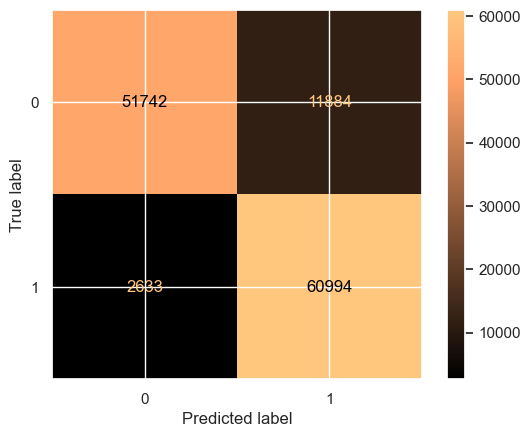

In [13]:
# number of images/comments on the review are the most important features, not good for our model
# we don't want to have 'review' information in our model's features, too much data leakage
contin_cols2 = ['price_low', 'num_reviews', 'num_images_pdp']

# rerun our SMOTEN and Random Forest for reduced set of continuous feature
smoten2 = SMOTEN()
# SMOTEN for continuous features

xcon_resam2, ycon_resam2 = smoten2.fit_resample(df[contin_cols2], y)

# train-test split for SMOTEN resample of continuous features
X_train2, X_test2, y_train2, y_test2 = train_test_split(xcon_resam2, ycon_resam2, stratify = ycon_resam2, random_state = 22)

# fit / score
rcon2 = RandomForestClassifier()

rcon2.fit(X_train2, y_train2)

print(f'Training set score: {rcon2.score(X_train2, y_train2)}')

print(f'5-fold cross-validated TEST set average: {cross_val_score(rcon2, X_test2, y_test2).mean()}')

# evaluation metrics
preds2 = rcon2.predict(X_test2)
evaluation(X_test2, y_test2, preds2, rcon2)

# slightly lower performance but still very good, and this time with no data leakage via reviews-data

Training set score: 0.9079414391877556
TEST set score: 0.9070670239601424
balanced_accuracy: 0.9070668220193594
recall: 0.9327643924748927
precision: 0.887169828243419
f1 score: 0.9093959731543624


{'balanced_accuracy': 0.9070668220193594,
 'recall': 0.9327643924748927,
 'precision': 0.887169828243419,
 'f1_score': 0.9093959731543624}

<Figure size 1000x800 with 0 Axes>

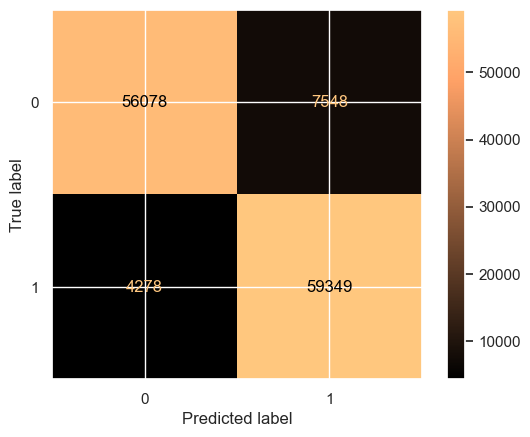

In [27]:
X_cols = ['price_low', 'num_reviews', 'num_images_pdp', # continuous features
          'is_prime', 'offer_merchant', 'brand', 'category'] # categorical features

# SMOTENC for continuous-categorical data
smote_nc = SMOTENC(categorical_features = [3, 4, 5, 6])

X_resamp, y_resamp = smote_nc.fit_resample(df[X_cols], y)

# OHE categorical variables
ohe_X_resamp = pd.get_dummies(X_resamp, columns = ['is_prime', 'offer_merchant', 'brand',
                                                   'category'], drop_first = True)

# train-test split
x_tra, x_tes, y_tra, y_tes = train_test_split(ohe_X_resamp, y_resamp, stratify = y_resamp,
                                              random_state = 22)

rfc = RandomForestClassifier()
# instatiate, fit, score Random Forest

rfc.fit(x_tra, y_tra)

print(f'Training set score: {rfc.score(x_tra, y_tra)}')

# not using cross-validation due to exploded dimensionality from OHE
print(f'TEST set score: {rfc.score(x_tes, y_tes)}')

rfc_preds = rfc.predict(x_tes)
evaluation(x_tes, y_tes, rfc_preds, rfc)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training set score: 0.5291900344983851
TEST set score: 0.5315945400108445
balanced_accuracy: 0.5315938184500979
recall: 0.6234145881465416
precision: 0.5266959673885621
f1 score: 0.5709884984669421


{'balanced_accuracy': 0.5315938184500979,
 'recall': 0.6234145881465416,
 'precision': 0.5266959673885621,
 'f1_score': 0.5709884984669421}

<Figure size 1000x800 with 0 Axes>

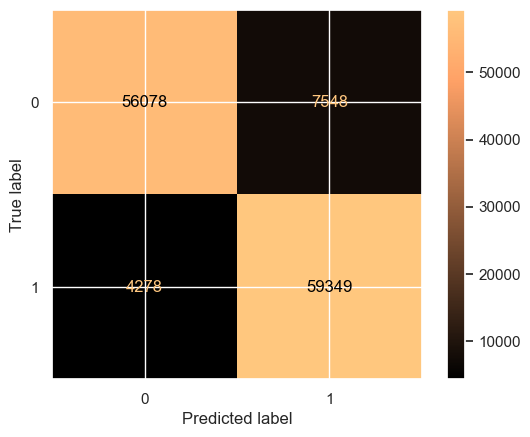

In [28]:
logreg = LogisticRegression(solver = 'saga', max_iter = 1_000)
# instatiate, fit, score Random Forest

logreg.fit(x_tra, y_tra)

print(f'Training set score: {logreg.score(x_tra, y_tra)}')

# not using cross-validation due to exploded dimensionality from OHE
print(f'TEST set score: {logreg.score(x_tes, y_tes)}')

logreg_preds = logreg.predict(x_tes)
evaluation(x_tes, y_tes, logreg_preds, rfc)

In [31]:
# features and coefficients
features_listed = []

for i in range(len(logreg.feature_names_in_)):
    features_listed.append({logreg.feature_names_in_[i] : logreg.coef_[0][i]})
    
features_listed

[{'price_low': 0.0008920947248097323},
 {'num_reviews': -2.902666275764548e-05},
 {'num_images_pdp': -0.003410575371797516},
 {'is_prime_True': -0.00033458086460535775},
 {'offer_merchant_2015 Beauty': -4.205848142773061e-08},
 {'offer_merchant_212 Distributors': -4.00013836056538e-07},
 {'offer_merchant_2K TIME LLC': -3.1384402378519075e-07},
 {'offer_merchant_2ndTimesaCharm': -7.032146286331621e-07},
 {'offer_merchant_37Watches': -4.3259151151165635e-07},
 {'offer_merchant_A Little Bit Of Fashion': -4.752127928083285e-08},
 {'offer_merchant_A&B Wireless': -3.319228624872866e-07},
 {'offer_merchant_A1 SERVICE': -2.961822374257636e-07},
 {'offer_merchant_AARYA SHOPPING': -8.250987942772966e-08},
 {'offer_merchant_ADVANCED ESSENTIALS': -2.520791205489062e-07},
 {"offer_merchant_AH Bargain's Galore": -4.948304080205231e-07},
 {'offer_merchant_AMAZING DEALS INC': -4.132629821201327e-07},
 {'offer_merchant_AVLGear': -4.789496909688745e-08},
 {'offer_merchant_AZPerfume': -5.462119510265078e

{'pca__n_components': 0.95, 'rfc__n_estimators': 500}
0.9081667133805013 0.9061004455690632
balanced_accuracy: 0.906100197498105
recall: 0.9376679711443255
precision: 0.8819850984566259
f1 score: 0.9089745640697489


{'balanced_accuracy': 0.906100197498105,
 'recall': 0.9376679711443255,
 'precision': 0.8819850984566259,
 'f1_score': 0.9089745640697489}

<Figure size 1000x800 with 0 Axes>

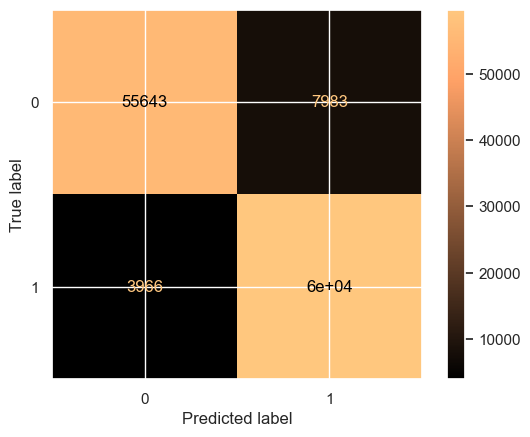

In [26]:
pca_pipe = Pipeline([
    ('pca', PCA()),
    ('rfc', RandomForestClassifier())
])

pca_params = {
    'pca__n_components': [0.95],
    'rfc__n_estimators': [500]
    
}

gs_pca = GridSearchCV(pca_pipe, param_grid = pca_params)

gs_pca.fit(x_tra, y_tra)

print(gs_pca.best_params_)

print(gs_pca.score(x_tra, y_tra), gs_pca.score(x_tes, y_tes))

pca_preds = gs_pca.predict(x_tes)

evaluation(x_tes, y_tes, pca_preds, gs_pca)

---